<h1><center>Stock Analysis</center></h1>

Import necessary libraries

In [61]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.econindicators import EconIndicators
from dotenv import load_dotenv
import os
import datetime
import requests as re
import json
from xgboost import XGBRegressor
from sklearn.datasets import make_regression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings


Import API and retrieve data

In [8]:
load_dotenv()
warnings.filterwarnings('ignore')

In [9]:
# Imports data.
ts = TimeSeries('api_key', output_format='pandas')

stock, meta = ts.get_daily(symbol='QBTS', outputsize='full')

stock.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-10-31,35.9900,37.435,35.055,37.06,37846555.0
2025-10-30,32.9100,36.790,32.450,36.11,44418015.0
2025-10-29,32.4750,34.650,32.000,34.26,47219167.0
2025-10-28,35.2954,36.570,31.850,32.00,64548472.0
2025-10-27,33.9900,37.280,33.230,35.04,65054302.0


In [10]:
# Create economic indicators object.
ei = EconIndicators('api_key', output_format = ' pandas')

In [11]:
# Create technical indicators object.
ta = TechIndicators('api_key', output_format = 'pandas')

In [12]:
# Create fundamental data object.
fd = FundamentalData('api_key' , output_format = 'pandas')

In [13]:
# Import sma for DWave.
qbts, meta = ta.get_sma(symbol='QBTS',interval='daily', 
time_period=60, series_type='close')

In [14]:
qbts_bb, meta = ta.get_bbands(symbol='QBTS', interval='daily',
time_period=60, series_type='close')

In [15]:
# Import dividend info for DWave.
qbts_div = fd.get_dividends('QBTS')

In [16]:
# View dividend dataframe.
qbts_div 

(Empty DataFrame
 Columns: []
 Index: [],
 'QBTS')

In [17]:
# Import stock split data.
qbts_split = fd.get_splits('QBTS')

In [18]:
# View stock split dataframe.
qbts_split

(Empty DataFrame
 Columns: []
 Index: [],
 'QBTS')

<h1><center>EDA</center><h1>

In [19]:
# View columns.
stock.columns

Index(['1. open', '2. high', '3. low', '4. close', '5. volume'], dtype='object')

In [20]:
# Rename columns.
stock.rename(columns={'1. open': 'open', '2. high': 'high', '3. low': 'low', 
'4. close': 'close', '5. volume': 'volume'}, inplace = True)

In [21]:
# View stock data data types
stock.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object

In [22]:
# Create a percent change column.
stock['pct_ch_clo'] = stock['close'].pct_change() * 100

In [23]:
# Round the percent change column to two places.
stock['pct_ch_clo'] = stock['pct_ch_clo'].round(2)

In [24]:
stock.head()

,open,high,low,close,volume,pct_ch_clo
date,,,,,,
2025-10-31,35.9900,37.435,35.055,37.06,37846555.0,NaN
2025-10-30,32.9100,36.790,32.450,36.11,44418015.0,-2.56
2025-10-29,32.4750,34.650,32.000,34.26,47219167.0,-5.12
2025-10-28,35.2954,36.570,31.850,32.00,64548472.0,-6.60
2025-10-27,33.9900,37.280,33.230,35.04,65054302.0,9.50


In [25]:
# Function to calculate Sharpe Ratio.
def calculate_sharp_ratio(ret, ann_rfr, periods):
    daily_rfr = ann_rfr/periods
    excess_ret = ret-daily_rfr
    mean_ex_ret = excess_ret.mean()
    std_ex_ret = excess_ret.std()

    if std_ex_ret == 0:
        return np.nan

    sharp_ratio = (mean_ex_ret/std_ex_ret) * np.sqrt(periods)

    return sharp_ratio

In [26]:
# call function to calculate Sharpe Ratio.
ann_rfr = 0.0377
periods = 252
ret = stock['pct_ch_clo']
sharpe = calculate_sharp_ratio(ret, ann_rfr, periods).round(2)
print(f"The Sharpe ratio for QBTS is:\n{sharpe}")

The Sharpe ratio for QBTS is:
0.44


In [27]:
# Merge stock with sma data frames.
stock_qbts = pd.merge(stock, qbts, on='date', how='inner')

In [28]:
# Fill any nan's with a 0.
stock_qbts = stock_qbts.fillna(0)

In [29]:
stock_qbts = pd.merge(stock_qbts, qbts_bb, on='date', how='inner')

In [30]:
# View the first five rows of the new data frame.
stock_qbts.head()

,open,high,low,close,volume,pct_ch_clo,SMA,Real Upper Band,Real Middle Band,Real Lower Band
date,,,,,,,,,,
2025-10-31,35.9900,37.435,35.055,37.06,37846555.0,0.00,24.9925,42.7833,24.9925,7.2017
2025-10-30,32.9100,36.790,32.450,36.11,44418015.0,-2.56,24.6610,42.2804,24.6610,7.0416
2025-10-29,32.4750,34.650,32.000,34.26,47219167.0,-5.12,24.3522,41.8069,24.3522,6.8975
2025-10-28,35.2954,36.570,31.850,32.00,64548472.0,-6.60,24.0862,41.4148,24.0862,6.7576
2025-10-27,33.9900,37.280,33.230,35.04,65054302.0,9.50,23.8392,41.1320,23.8392,6.5464


<h1><center>Visualizations</center></h1>

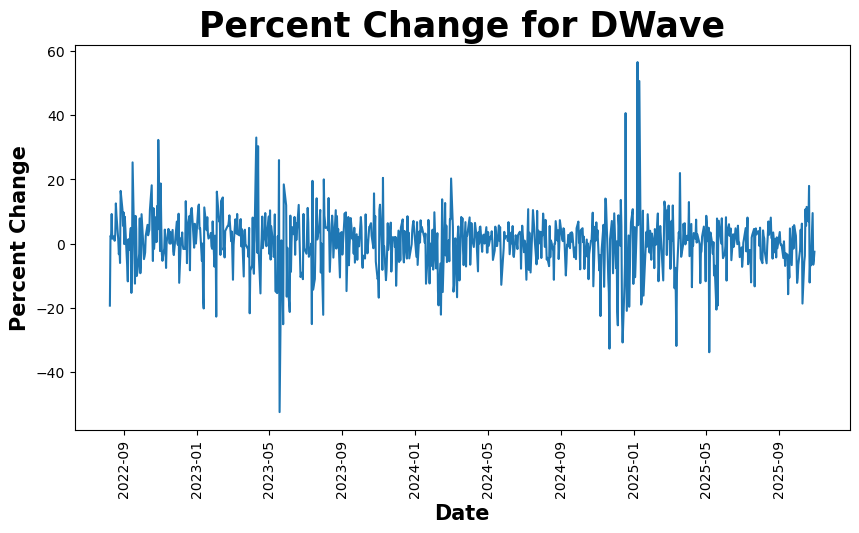

In [31]:
# graph percent change for DWave.
plt.figure(figsize=(10,5))
sns.lineplot(stock, x = 'date', y = 'pct_ch_clo')
plt.title('Percent Change for DWave', fontsize=25, weight='bold')
plt.xlabel('Date', fontsize=15, weight='bold')
plt.ylabel('Percent Change', fontsize=15, weight='bold')
plt.xticks(rotation=90)
plt.show()

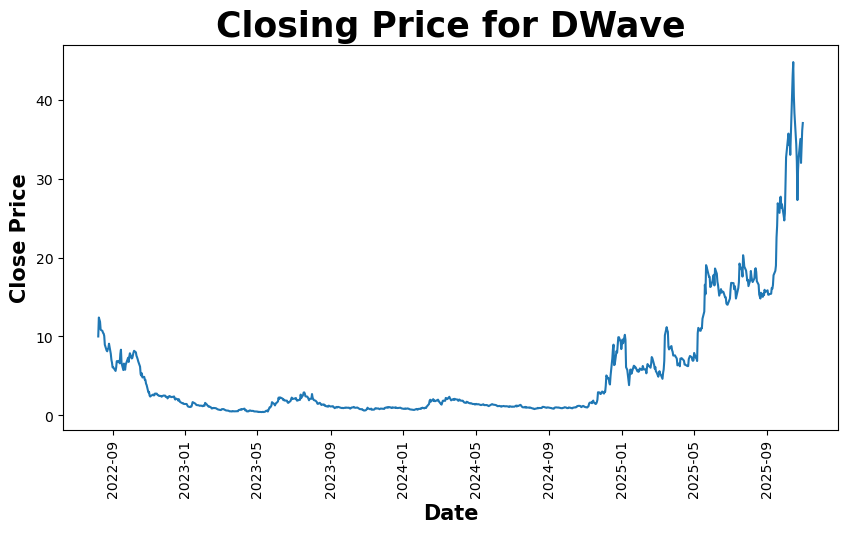

In [32]:
# Graph the closing price of DWave. 
plt.figure(figsize=(10,5))
sns.lineplot(stock, x = 'date', y = 'close')
plt.title('Closing Price for DWave', fontsize = 25, weight = 'bold')
plt.xlabel('Date', fontsize = 15, weight = 'bold')
plt.ylabel('Close Price', fontsize = 15, weight = 'bold')
plt.xticks(rotation= 90)
plt.show()

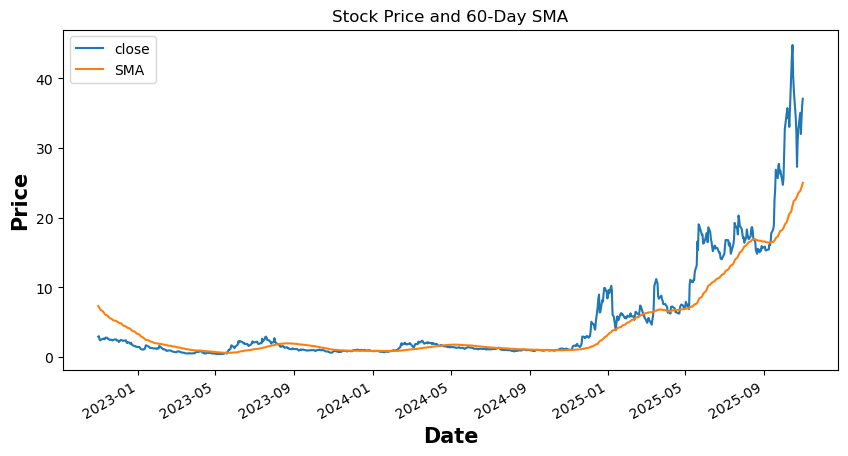

In [33]:
# Graph SMA.
window_size = 60
stock_qbts[['close', 'SMA']].plot(figsize = (10,5), 
title=f'Stock Price and {window_size}-Day SMA')
plt.xlabel('Date', fontsize = 15, weight = 'bold')
plt.ylabel('Price', fontsize = 15, weight = 'bold')
plt.show()

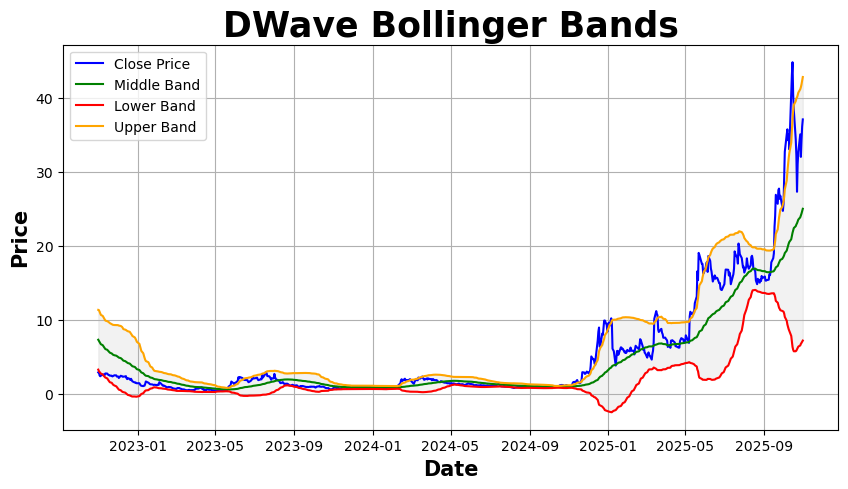

In [34]:
plt.figure(figsize=(10,5))
plt.plot(stock_qbts['close'], label = 'Close Price', color='blue')
plt.plot(stock_qbts['Real Middle Band'], label = 'Middle Band', color = 'green')
plt.plot(stock_qbts['Real Lower Band'], label = 'Lower Band', color = 'red')
plt.plot(stock_qbts['Real Upper Band'], label = 'Upper Band', color = 'orange')
plt.fill_between(stock_qbts.index, stock_qbts['Real Lower Band'], 
stock_qbts['Real Upper Band'], color = 'gray', alpha = 0.1)
plt.title('DWave Bollinger Bands', fontsize = 25, weight = 'bold')
plt.xlabel('Date', fontsize = 15, weight = 'bold')
plt.ylabel('Price', fontsize = 15, weight = 'bold')
plt.legend()
plt.grid(True)
plt.show()

<h1><center>Regression with XG Boost</center></h1>

In this section we will build a regression model using XG Boost. The goal is to determine if we can predict future price for D Wave Stock.

In [ ]:
# Split stock_qbts data into X and y data sets.
X = stock_qbts.drop(columns ='close')
y = stock_qbts['close']

In [ ]:
# Split X and y into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, 
random_state = 19)

In [ ]:
# Print the shape of the training and testing sets.
x_t = X_train.shape
x_t_1 = X_test.shape
y_t = y_train.shape
y_t_1 = y_test.shape
print(f"The shape of the X_train data is: {x_t}")
print(f"The shape of the X_test data is: {x_t_1}")
print(f"The shape of the y_train data is: {y_t}")
print(f"The shape of the y_test data is: {y_t_1}")


The shape of the X_train data is: (527, 9)
The shape of the X_test data is: (227, 9)
The shape of the y_train data is: (527,)
The shape of the y_test data is: (227,)


In [ ]:
# Build XGBoost regressor model
model = XGBRegressor()

In [ ]:
# Train model with training data.
model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
# Test model with testing data.
y_pred = model.predict(X_test)

In [ ]:
# Run MSE.
mse = mean_squared_error(y_test, y_pred)
rounded_mse = round(mse, 2)
print(f"The MSE is: {rounded_mse}")


The MSE is: 0.27


In [ ]:
# Run R-Squared.
r_2 = r2_score(y_test, y_pred)
rounded_r2 = round(r_2, 2)
print(f"The R2 Score is: {rounded_r2}")

The R2 Score is: 0.99


In [68]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0,0.1]
}

In [69]:
grid_search = GridSearchCV(estimator= XGBRegressor(), param_grid= param_grid,
cv = 5, scoring = 'neg_mean_squared_error', verbose= 1 )

In [70]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1], 'gamma': [0, 0.1], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 7], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [71]:
grid_search.best_params_

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 150,
 'subsample': 0.8}

In [73]:
y_pred_tuned = grid_search.best_estimator_.predict(X_test)

In [76]:
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
mse_tuned_rounded = round(mse_tuned, 2)
print(f"'The MSE tuned is: {mse_tuned_rounded}")

'The MSE tuned is: 0.3


In [77]:
r2_tuned = r2_score(y_test, y_pred_tuned)
r2_tuned_rounded = round(r2_tuned, 2)
print(f"The R Squared Tuned is: {r2_tuned_rounded}")

The R Squared Tuned is: 0.99
